In [1]:
from IPython.core.interactiveshell import InteractiveShell   #Allowing for multiline output
InteractiveShell.ast_node_interactivity = "all"

## Importing Modules and Creating Workflow

In [2]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import pandas_flavor as pf
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from statistics import stdev
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.combine import SMOTETomek
import scikitplot as skplt

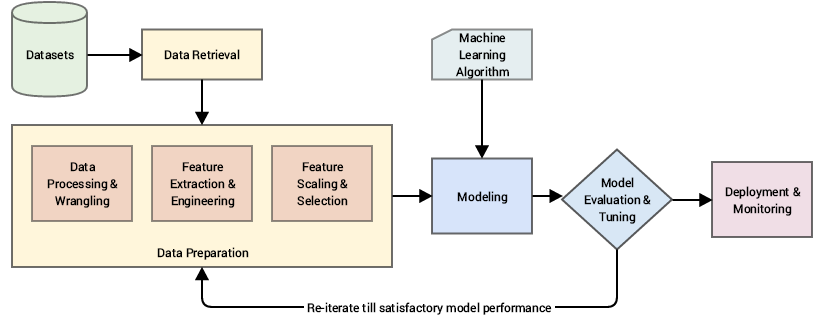

In [3]:
img = Image.open('workflow.png')
display(img)

## Data Exploration

In [5]:
#Reading in different data files and analyzing first few rows of each data set
training_df = pd.read_csv('HPE_TRAIN.csv') #Airport_codes -> ac
testing_df = pd.read_csv('HPE_TEST.csv')

In [6]:
training_df.shape # We will split training data into training and validation
testing_df.shape # We will not touching testing data for now

(46332, 34)

(19857, 33)

In [7]:
training_df.purchase_event.value_counts(normalize=True)
training_df.past_purchase_networking.value_counts(normalize=True)
training_df.past_purchase_cloud.value_counts(normalize=True) # We can clearly see that purhcase_event should have much higher values 

0    0.949258
1    0.050742
Name: purchase_event, dtype: float64

0    0.83778
1    0.16222
Name: past_purchase_networking, dtype: float64

0    0.997691
1    0.002309
Name: past_purchase_cloud, dtype: float64

In [8]:
training_df['purchase_event_c'] = training_df.purchase_event + training_df.past_purchase_networking + training_df.past_purchase_cloud

In [9]:
training_df.purchase_event_c.value_counts(normalize=True)

0    0.795282
1    0.194380
2    0.010123
3    0.000216
Name: purchase_event_c, dtype: float64

In [10]:
def purchase(row):
    if row['purchase_event_c'] == 1:
            return 1
    elif row['purchase_event_c'] == 2:
            return 1
    elif row['purchase_event_c'] == 3:
            return 1
    else:
        return 0

In [11]:
training_df['purchase_event_c'] = training_df.apply(lambda row: purchase(row), axis =1)

In [12]:
training_df.purchase_event.value_counts(normalize=True)
training_df.purchase_event_c.value_counts(normalize=True)
training_df.past_purchase_networking.value_counts(normalize=True)
training_df.past_purchase_cloud.value_counts(normalize=True)

0    0.949258
1    0.050742
Name: purchase_event, dtype: float64

0    0.795282
1    0.204718
Name: purchase_event_c, dtype: float64

0    0.83778
1    0.16222
Name: past_purchase_networking, dtype: float64

0    0.997691
1    0.002309
Name: past_purchase_cloud, dtype: float64

In [13]:
def format_col_name(df):
    df.columns = df.columns.str.strip().str.lower()
    return df

format_col_name(training_df)
format_col_name(testing_df)

,account_id,number_contacts,it_spend_networking,decision_maker,email_acitivity,it_spend_cloud,it_spend_others,past_purchase_networking,number_employees_10k_50k,web_acitivity_cloud,...,competitor_1_networking,competitor_3_networking,industry_vertical_retail,paid_media_activity,industry_vertical_healthcare,persona_executive,persona_manager,purchase_event,persona_tech,purchase_event_c
0,37642,3,61303261.0,0,76,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.0,0
1,19806,1,38554008.0,0,53,519366,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
2,2427,0,16948797.0,0,16,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.0,0
3,13073,1,0.0,1,33,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
4,56025,7,149449820.0,0,36,4713370,504320,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46327,9980,1,0.0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1.0,0
46328,53180,7,0.0,0,31,3388599,292939,0,1,0,...,0,0,0,0,0,1,0,0,1.0,0
46329,13937,1,0.0,1,53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0
46330,61156,9,159043030.0,1,77,4790522,237104,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0


,account_id,number_contacts,it_spend_networking,decision_maker,email_acitivity,it_spend_cloud,it_spend_others,past_purchase_networking,number_employees_10k_50k,web_acitivity_cloud,...,competitor_2_cloud,competitor_1_cloud,competitor_1_networking,competitor_3_networking,industry_vertical_retail,paid_media_activity,industry_vertical_healthcare,persona_executive,persona_manager,persona_tech
0,65279,13,120764481.0,0,17,5700402,366929,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
1,65754,15,20316792.0,1,12,8987076,1026978,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,30105,2,0.0,1,36,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0.0
3,2226,0,8892578.0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,62780,10,171311969.0,1,48,6934894,796178,1,1,1,...,0,0,0,0,0,1,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19852,18699,1,30253589.0,0,28,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
19853,8170,1,0.0,0,34,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1.0
19854,43903,4,142572652.0,0,17,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
19855,1971,0,230882.0,0,19,1298518,47473,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [14]:
train = training_df.drop(['account_id','past_purchase_networking','past_purchase_cloud','purchase_event'], axis = 1).copy() # We will split training data into training and validation
test = testing_df.drop(['account_id','past_purchase_networking','past_purchase_cloud'], axis = 1).copy() # We will not touching testing data for now

In [15]:
train_df, valid_df = train_test_split(train,test_size=0.3, stratify= train.purchase_event_c, random_state= 42)

In [16]:
train_df.shape, training_df.shape

((32432, 31), (46332, 35))

In [17]:
train_df.shape, valid_df.shape

((32432, 31), (13900, 31))

In [18]:
train_df.head()

,number_contacts,it_spend_networking,decision_maker,email_acitivity,it_spend_cloud,it_spend_others,number_employees_10k_50k,web_acitivity_cloud,industry_vertical_infrastructure,decision_headquarter,...,competitor_1_cloud,competitor_1_networking,competitor_3_networking,industry_vertical_retail,paid_media_activity,industry_vertical_healthcare,persona_executive,persona_manager,persona_tech,purchase_event_c
36404,1,73640451.0,1,26,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1.0,0
34291,1,0.0,0,13,0,258167,0,0,0,1,...,0,0,0,0,0,0,0,0,1.0,0
45206,1,0.0,0,0,0,168754,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
40867,11,54606626.0,1,3,1235234,352085,0,0,0,1,...,0,0,1,0,0,0,1,0,0.0,1
2898,1,114426146.0,1,0,653372,36005,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1


In [19]:
train_df['cloud_others'] = train_df.it_spend_cloud + train_df.it_spend_others
train_df.drop(['it_spend_cloud','it_spend_others'],axis=1, inplace =True)

valid_df['cloud_others'] = valid_df.it_spend_cloud + valid_df.it_spend_others
valid_df.drop(['it_spend_cloud','it_spend_others'],axis=1, inplace =True)

test['cloud_others'] = test.it_spend_cloud + test.it_spend_others
test.drop(['it_spend_cloud','it_spend_others'],axis=1, inplace =True)

train_df.shape, valid_df.shape, test.shape

((32432, 30), (13900, 30), (19857, 29))

## Feature Cleaning

In [20]:
train_df.email_acitivity.kurtosis()
train_df.email_acitivity.skew()

0.20578798204209292

0.8818461113312848

In [21]:
train_df.number_contacts.kurtosis()
train_df.number_contacts.skew()

70.88533676250718

2.9114129843969705

In [22]:
def apply_log1p_transformation(dataframe, column):
    '''This function takes a dataframe and a column in the string format
    then applies numpy log1p transformation to the column
    as a result returns log1p applied pandas series'''
    
    dataframe["log_" + column] = np.log1p(dataframe[column])
    return dataframe["log_" + column]

In [23]:
apply_log1p_transformation(train_df,'number_contacts')
apply_log1p_transformation(train_df,'it_spend_networking')
apply_log1p_transformation(train_df,'cloud_others')

36404    0.693147
34291    0.693147
45206    0.693147
40867    2.484907
2898     0.693147
           ...   
13338    0.693147
24084    0.693147
35040    2.564949
41741    1.386294
24905    0.693147
Name: log_number_contacts, Length: 32432, dtype: float64

36404    18.114705
34291     0.000000
45206     0.000000
40867    17.815666
2898     18.555440
           ...    
13338    16.598860
24084     0.000000
35040    18.626788
41741    18.657718
24905     0.000000
Name: log_it_spend_networking, Length: 32432, dtype: float64

36404     0.000000
34291    12.461366
45206    12.036203
40867    14.277558
2898     13.443545
           ...    
13338     0.000000
24084    12.698333
35040    16.106662
41741    13.862773
24905     0.000000
Name: log_cloud_others, Length: 32432, dtype: float64

In [24]:
train_df.drop(['number_contacts','it_spend_networking','cloud_others'], axis = 1, inplace =True)

In [25]:
apply_log1p_transformation(valid_df,'number_contacts')
apply_log1p_transformation(valid_df,'it_spend_networking')
apply_log1p_transformation(valid_df,'cloud_others')

34778    2.397895
903      0.693147
18026    2.197225
22687    2.564949
33757    1.791759
           ...   
33645    1.386294
42956    0.693147
24682    1.609438
7009     1.386294
34384    2.302585
Name: log_number_contacts, Length: 13900, dtype: float64

34778     0.000000
903      17.804346
18026    17.792210
22687    18.414017
33757    14.251963
           ...    
33645    18.464226
42956     0.000000
24682     0.000000
7009      0.000000
34384    16.343337
Name: log_it_spend_networking, Length: 13900, dtype: float64

34778    16.102993
903      14.073423
18026    14.691442
22687    16.057719
33757     0.000000
           ...    
33645    14.767951
42956     0.000000
24682    14.276159
7009     14.982333
34384    13.553579
Name: log_cloud_others, Length: 13900, dtype: float64

In [26]:
valid_df.drop(['number_contacts','it_spend_networking','cloud_others'], axis = 1, inplace =True)

In [27]:
apply_log1p_transformation(test,'number_contacts')
apply_log1p_transformation(test,'it_spend_networking')
apply_log1p_transformation(test,'cloud_others')

0        2.639057
1        2.772589
2        1.098612
3        0.000000
4        2.397895
           ...   
19852    0.693147
19853    0.693147
19854    1.609438
19855    0.000000
19856    1.945910
Name: log_number_contacts, Length: 19857, dtype: float64

0        18.609353
1        16.826958
2         0.000000
3        16.000728
4        18.958997
           ...    
19852    17.225125
19853     0.000000
19854    18.775362
19855    12.349666
19856    18.357065
Name: log_it_spend_networking, Length: 19857, dtype: float64

0        15.618430
1        16.119500
2         0.000000
3         0.000000
4        15.860758
           ...    
19852     0.000000
19853     0.000000
19854     0.000000
19855    14.112642
19856    16.088289
Name: log_cloud_others, Length: 19857, dtype: float64

In [28]:
test.drop(['number_contacts','it_spend_networking','cloud_others'], axis = 1, inplace =True)

In [29]:
def conf_matrix(y_test, pred_test):    
    
    ax= plt.subplot()
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

<AxesSubplot:xlabel='purchase_event_c', ylabel='count'>

0    0.795295
1    0.204705
Name: purchase_event_c, dtype: float64

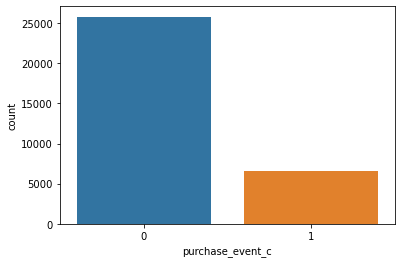

In [30]:
sns.countplot(data = train_df, x = 'purchase_event_c') # We can see that the data is extremely skewed towards unlikely to purhcase. 
train_df.purchase_event_c.value_counts(normalize= True) # Only 5% is the train dataset is 1.

In [31]:
corr_matrix = train_df.corr()
corr_matrix['purchase_event_c'].sort_values(ascending = False) #Overall there is very little correlation between the independent variables and target.



purchase_event_c                     1.000000
paid_media_activity                  0.184319
web_activity_networking              0.140975
competitor_2_networking              0.140524
web_acitivity_cloud                  0.139026
decision_headquarter                 0.118640
competitor_3_cloud                   0.116763
competitor_2_cloud                   0.107443
competitor_3_networking              0.094834
competitor_1_networking              0.090661
competitor_1_cloud                   0.055354
decision_power                       0.053752
persona_tech                         0.053133
chat_activity                        0.042010
number_employees_greater_than_50k    0.036449
industry_vertical_finance            0.015315
industry_vertical_healthcare         0.014075
number_employess_less_than 1000      0.002736
persona_executive                   -0.003780
number_employees_1000_10k           -0.006052
email_acitivity                     -0.006897
industry_vertical_infrastructure  

<Figure size 3600x3600 with 0 Axes>

<AxesSubplot:>

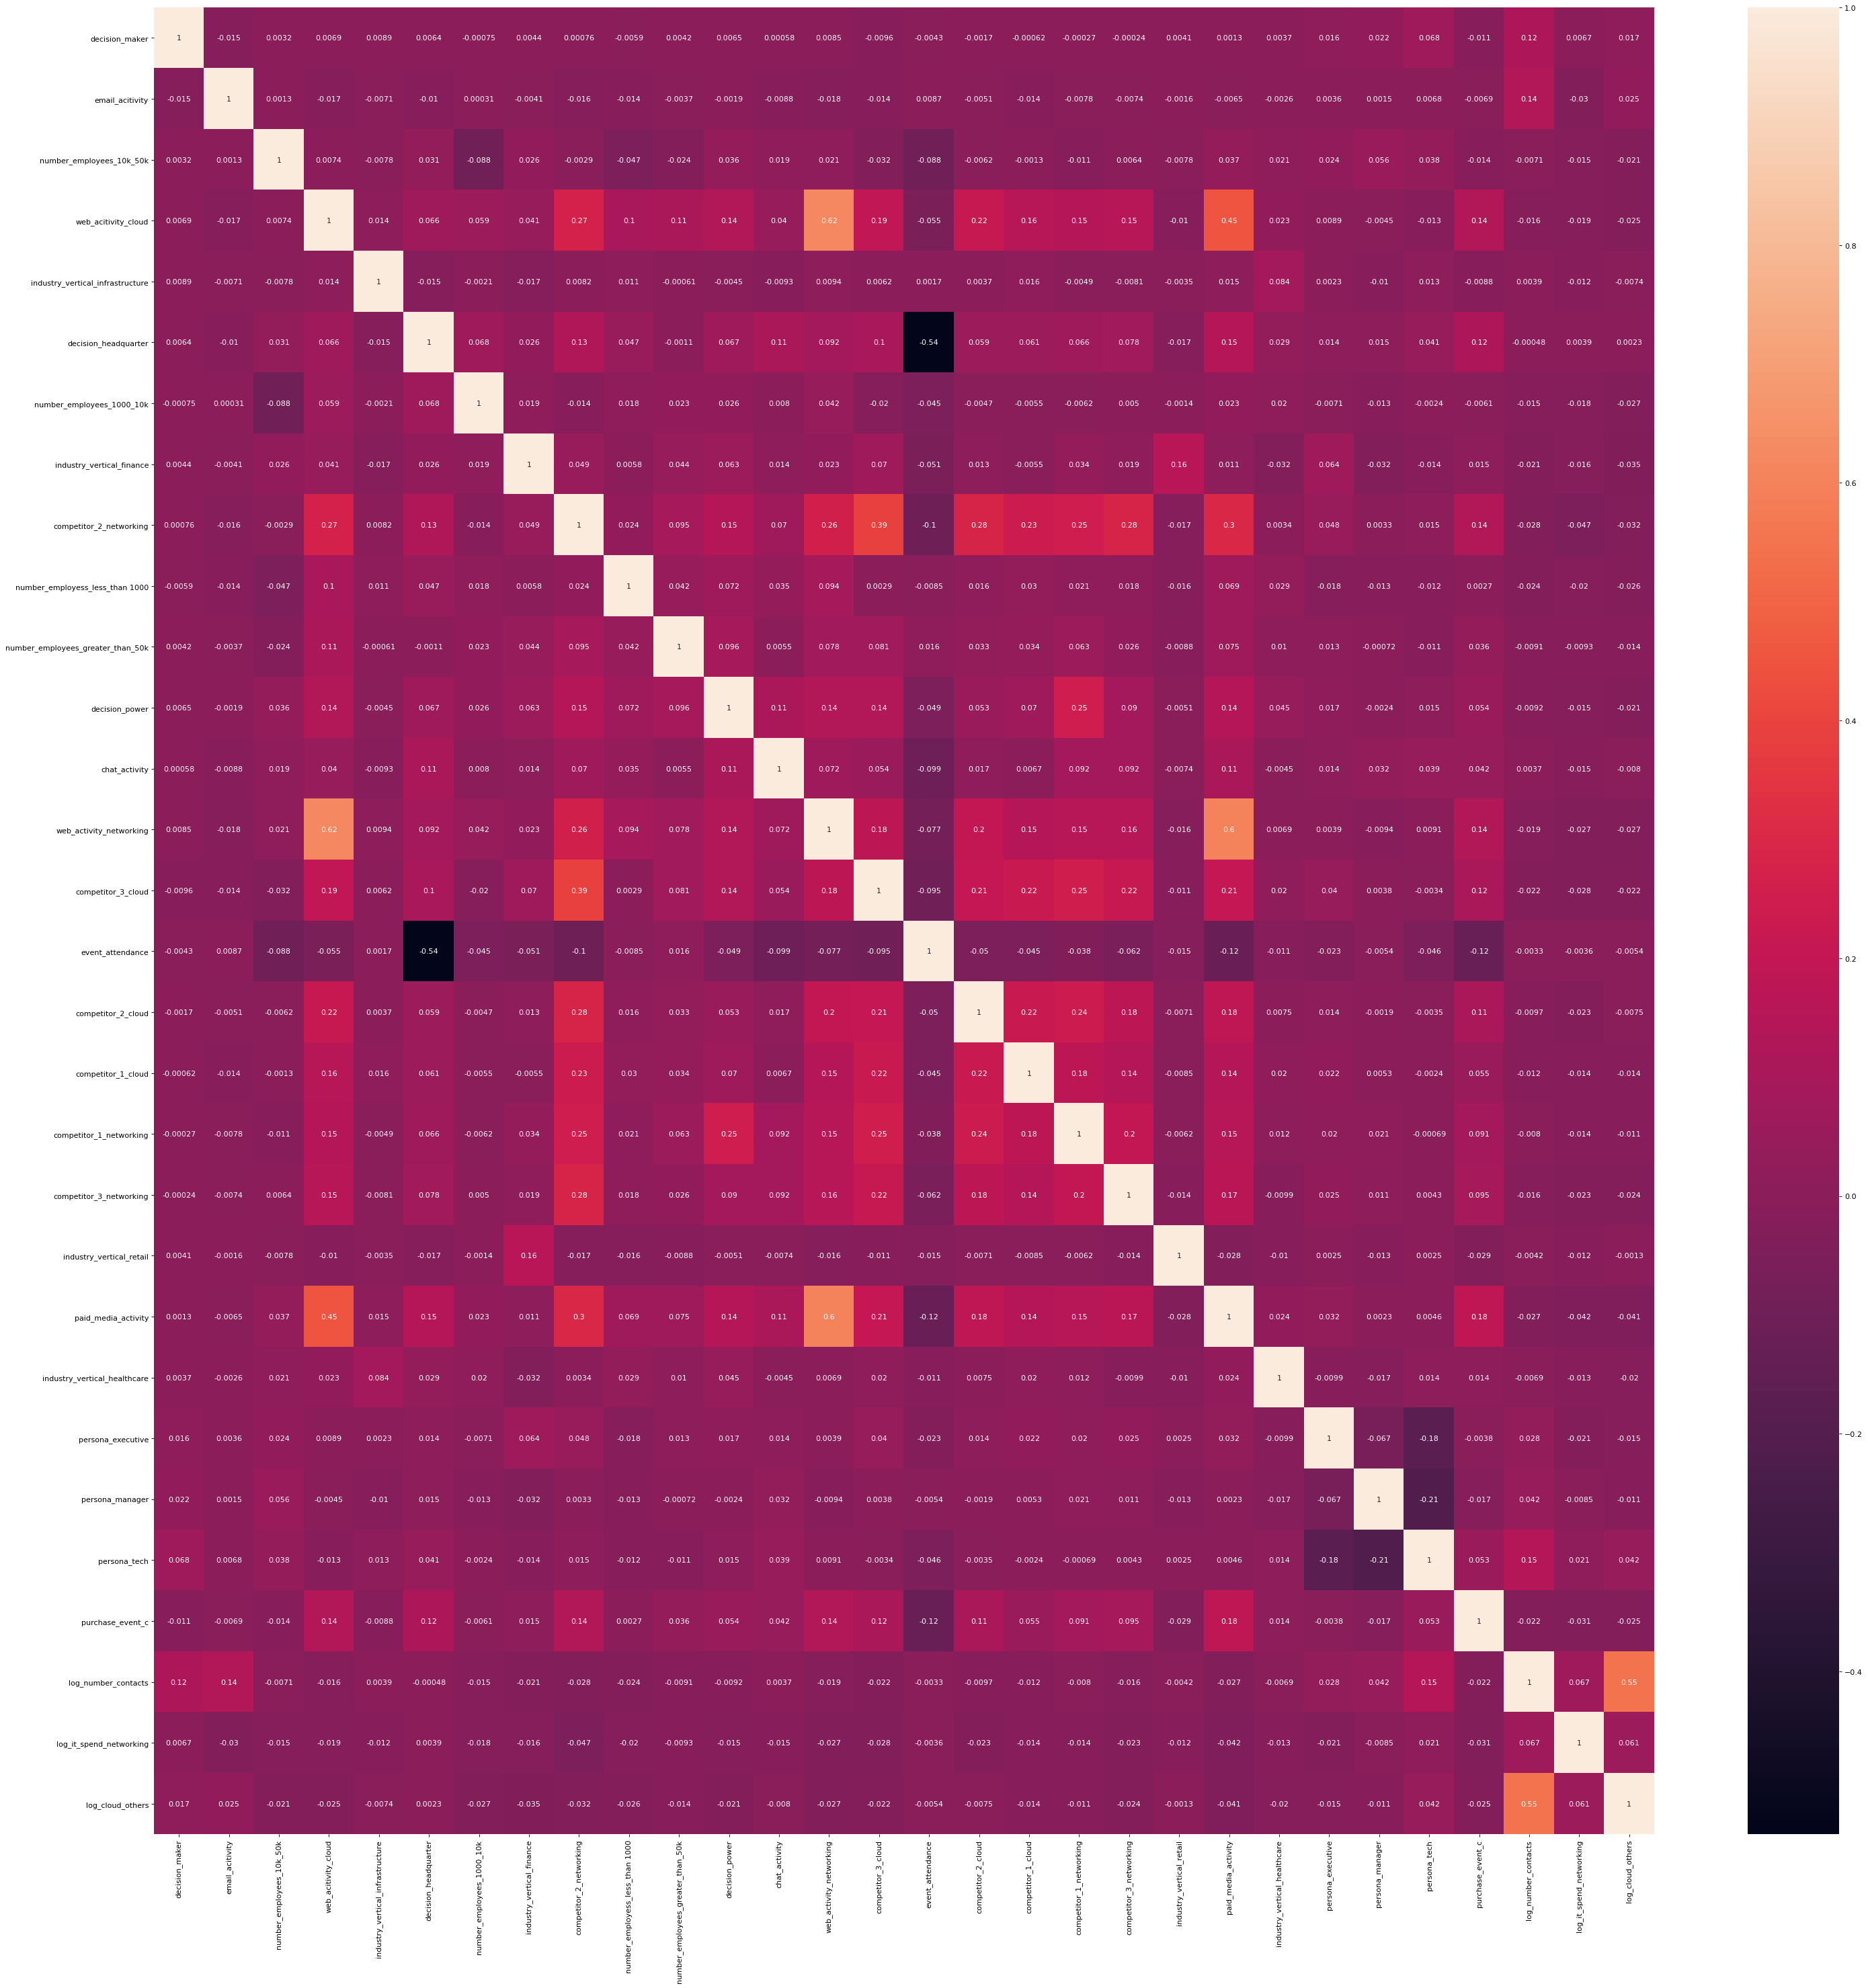

In [32]:
from matplotlib.pyplot import figure

figure(figsize=(45, 45), dpi=80)

sns.heatmap(corr_matrix, annot=True)
plt.show()

# We can see that it_spend_cloud is highly corellated to it_spend_others. Also, number of contacts and spends have an average correlation

#There is not much collinearity between the other independent variables. 

In [33]:
train_df.shape, valid_df.shape, test.shape

((32432, 30), (13900, 30), (19857, 29))

In [34]:
train_df.persona_tech.mode()

0    1.0
dtype: float64

In [35]:
train_df.isnull().any()
valid_df.isnull().any()
test.isnull().any()

decision_maker                       False
email_acitivity                      False
number_employees_10k_50k             False
web_acitivity_cloud                  False
industry_vertical_infrastructure     False
decision_headquarter                 False
number_employees_1000_10k            False
industry_vertical_finance            False
competitor_2_networking              False
number_employess_less_than 1000      False
number_employees_greater_than_50k    False
decision_power                       False
chat_activity                        False
web_activity_networking              False
competitor_3_cloud                   False
event_attendance                     False
competitor_2_cloud                   False
competitor_1_cloud                   False
competitor_1_networking              False
competitor_3_networking              False
industry_vertical_retail             False
paid_media_activity                  False
industry_vertical_healthcare         False
persona_exe

decision_maker                       False
email_acitivity                      False
number_employees_10k_50k             False
web_acitivity_cloud                  False
industry_vertical_infrastructure     False
decision_headquarter                 False
number_employees_1000_10k            False
industry_vertical_finance            False
competitor_2_networking              False
number_employess_less_than 1000      False
number_employees_greater_than_50k    False
decision_power                       False
chat_activity                        False
web_activity_networking              False
competitor_3_cloud                   False
event_attendance                     False
competitor_2_cloud                   False
competitor_1_cloud                   False
competitor_1_networking              False
competitor_3_networking              False
industry_vertical_retail             False
paid_media_activity                  False
industry_vertical_healthcare         False
persona_exe

decision_maker                       False
email_acitivity                      False
number_employees_10k_50k             False
web_acitivity_cloud                  False
industry_vertical_infrastructure     False
decision_headquarter                 False
number_employees_1000_10k            False
industry_vertical_finance            False
competitor_2_networking              False
number_employess_less_than 1000      False
number_employees_greater_than_50k    False
decision_power                       False
chat_activity                        False
web_activity_networking              False
competitor_3_cloud                   False
event_attendance                     False
competitor_2_cloud                   False
competitor_1_cloud                   False
competitor_1_networking              False
competitor_3_networking              False
industry_vertical_retail             False
paid_media_activity                  False
industry_vertical_healthcare         False
persona_exe

In [36]:
values = {"persona_tech": 1}
train_df = train_df.fillna(value = values)
valid_df = valid_df.fillna(value = values)
test= test.fillna(value = values)

In [37]:
train_df.isnull().any().sum()
valid_df.isnull().any().sum()
test.isnull().any().sum()

0

0

0

In [38]:
train_df.head()

,decision_maker,email_acitivity,number_employees_10k_50k,web_acitivity_cloud,industry_vertical_infrastructure,decision_headquarter,number_employees_1000_10k,industry_vertical_finance,competitor_2_networking,number_employess_less_than 1000,...,industry_vertical_retail,paid_media_activity,industry_vertical_healthcare,persona_executive,persona_manager,persona_tech,purchase_event_c,log_number_contacts,log_it_spend_networking,log_cloud_others
36404,1,26,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1.0,0,0.693147,18.114705,0.000000
34291,0,13,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1.0,0,0.693147,0.000000,12.461366
45206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.693147,0.000000,12.036203
40867,1,3,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0.0,1,2.484907,17.815666,14.277558
2898,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,1,0.693147,18.555440,13.443545


## Spliting into X and y

In [39]:
X_train = train_df.drop('purchase_event_c',axis = 1)
y_train = train_df.purchase_event_c

In [40]:
X_valid = valid_df.drop('purchase_event_c',axis = 1)
y_valid = valid_df.purchase_event_c

In [41]:
X_train.shape , y_train.shape , X_valid.shape , y_valid.shape, test.shape

((32432, 29), (32432,), (13900, 29), (13900,), (19857, 29))

## Feature Selection

In [42]:
def recursive_feature_addition_rf(X_train,y_train,X_test,y_test,
                                     tol=0.001,max_depth=None,
                                     class_weight=None,
                                     top_n=15,n_estimators=50,random_state=0):
    
   
    features_to_keep = [X_train.columns[0]]
    count = 1
    # initial model using only one feature
    model_one_feature = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                    random_state=random_state,class_weight=class_weight,
                                    n_jobs=-1)
    
    model_one_feature.fit(X_train[[X_train.columns[0]]], y_train)
    y_pred_test = model_one_feature.predict_proba(X_test[[X_train.columns[0]]])[:, 1]  
    auc_score_all = roc_auc_score(y_test, y_pred_test)
    
    for feature in X_train.columns[1:]:
        print()
        print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(X_train.columns))
        count += 1
        model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                    random_state=random_state,class_weight=class_weight,
                                    n_jobs=-1)
        
        # fit model with  the selected features
        # and the feature to be evaluated
        model.fit(X_train[features_to_keep + [feature]], y_train)
        y_pred_test = model.predict_proba(
                    X_test[features_to_keep + [feature]])[:, 1]    
        auc_score_int = roc_auc_score(y_test, y_pred_test)
        print('New Test ROC AUC={}'.format((auc_score_int)))
    
        # print the original roc-auc with all the features
        print('All features Test ROC AUC={}'.format((auc_score_all)))
    
        # determine the drop in the roc-auc
        diff_auc = auc_score_int - auc_score_all
    
        # compare the drop in roc-auc with the tolerance
        if diff_auc >= tol:
            # if the increase in the roc is bigger than the threshold
            # we keep the feature and re-adjust the roc-auc to the new value
            # considering the added feature
            print('Increase in ROC AUC={}'.format(diff_auc))
            print('keep: ', feature)
            auc_score_all = auc_score_int
            features_to_keep.append(feature)
        else:
            print('Increase in ROC AUC={}'.format(diff_auc))
            print('remove: ', feature)          

    print('DONE!!')
    print('total features to keep: ', len(features_to_keep))  
   
    return features_to_keep

In [43]:
features_to_keep = recursive_feature_addition_rf(X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_valid,
                                                        y_test=y_valid,
                                                        tol=0.001)


testing feature:  email_acitivity  which is feature  1  out of  29
New Test ROC AUC=0.503198140833201
All features Test ROC AUC=0.505115785651248
Increase in ROC AUC=-0.0019176448180470151
remove:  email_acitivity

testing feature:  number_employees_10k_50k  which is feature  2  out of  29
New Test ROC AUC=0.5109281612618869
All features Test ROC AUC=0.505115785651248
Increase in ROC AUC=0.0058123756106388536
keep:  number_employees_10k_50k

testing feature:  web_acitivity_cloud  which is feature  3  out of  29
New Test ROC AUC=0.5450895978484718
All features Test ROC AUC=0.5109281612618869
Increase in ROC AUC=0.03416143658658488
keep:  web_acitivity_cloud

testing feature:  industry_vertical_infrastructure  which is feature  4  out of  29
New Test ROC AUC=0.5456163990712686
All features Test ROC AUC=0.5450895978484718
Increase in ROC AUC=0.0005268012227968022
remove:  industry_vertical_infrastructure

testing feature:  decision_headquarter  which is feature  5  out of  29
New Test RO

In [44]:
features_to_keep

['decision_maker',
 'number_employees_10k_50k',
 'web_acitivity_cloud',
 'decision_headquarter',
 'number_employees_1000_10k',
 'industry_vertical_finance',
 'competitor_2_networking',
 'web_activity_networking',
 'event_attendance',
 'competitor_1_networking',
 'competitor_3_networking',
 'industry_vertical_retail',
 'paid_media_activity',
 'persona_tech']

## Testing Different Models

### Logistic Regression

In [45]:
std = StandardScaler()
preprocess = make_column_transformer(
    (std, ['email_acitivity','log_number_contacts','log_it_spend_networking','log_cloud_others']),
    remainder = 'passthrough'
)

clf = make_pipeline(
    preprocess,
    LogisticRegression(random_state=42))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

The f1 score for the testing data: 0.12967581047381546
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.673


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

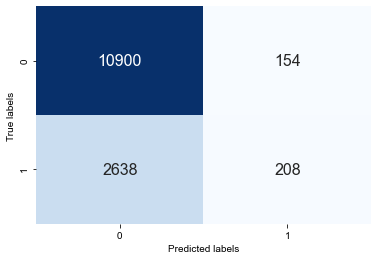

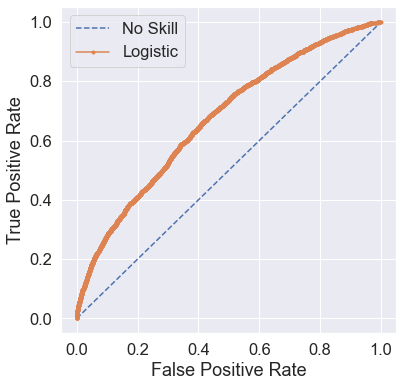

In [46]:
clf.fit(X_train, y_train)

# Predicting on the test data
pred_test = clf.predict(X_valid)

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = clf.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

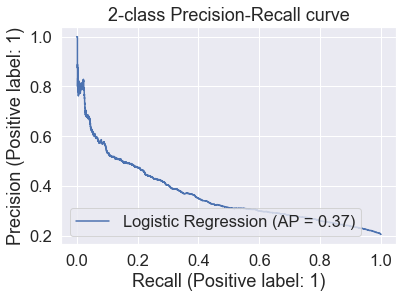

In [47]:
from sklearn.metrics import PrecisionRecallDisplay

y_score = clf.decision_function(X_valid)

display = PrecisionRecallDisplay.from_predictions(y_valid, y_score, name="Logistic Regression")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### EasyEnsembleClassifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

[[7005 4049]
 [1143 1703]]
0.6264748201438849
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     11054
           1       0.30      0.60      0.40      2846

    accuracy                           0.63     13900
   macro avg       0.58      0.62      0.56     13900
weighted avg       0.74      0.63      0.66     13900

The f1 score for the testing data: 0.39613863689230056
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.670


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

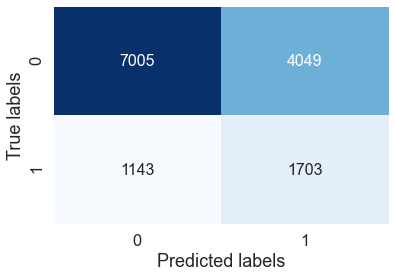

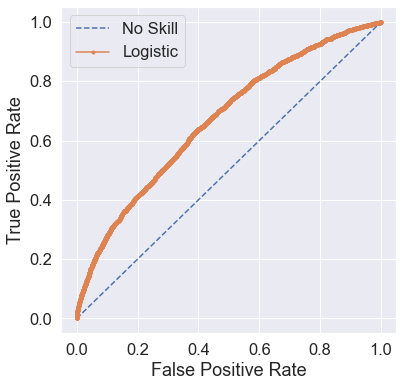

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

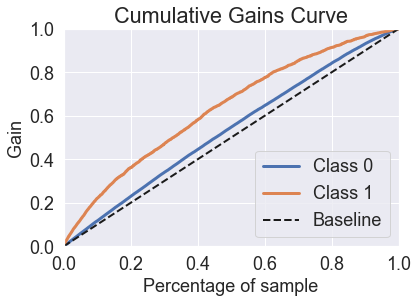

In [48]:
easy = make_pipeline(
    preprocess,
    EasyEnsembleClassifier())

easy.fit(X_train, y_train)

# Predicting on the test data
pred_test = easy.predict(X_valid)
print(confusion_matrix(y_valid,pred_test))
print(accuracy_score(y_valid,pred_test))
print(classification_report(y_valid,pred_test))

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = easy.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

import scikitplot as skplt
# Deriving Class probabilities
predicted_probabilities = easy.predict_proba(X_valid)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probabilities)

### BalacedRandomForestClassifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier())])

[[6907 4147]
 [1160 1686]]
0.6182014388489209
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     11054
           1       0.29      0.59      0.39      2846

    accuracy                           0.62     13900
   macro avg       0.57      0.61      0.56     13900
weighted avg       0.74      0.62      0.65     13900

The f1 score for the testing data: 0.3885240235050121
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.652


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

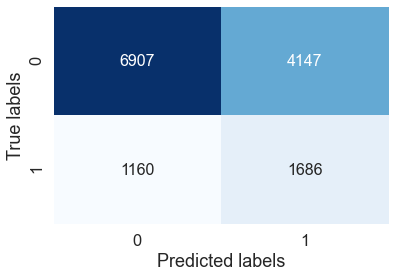

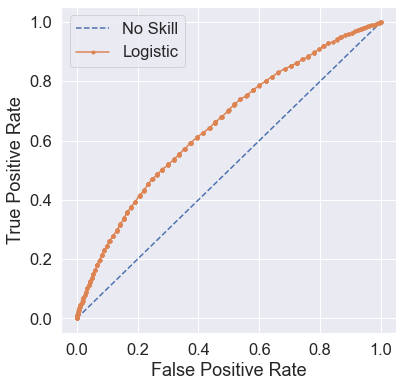

In [49]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = make_pipeline(
    preprocess,
    BalancedRandomForestClassifier())

brf.fit(X_train, y_train)

# Predicting on the test data
pred_test = brf.predict(X_valid)
print(confusion_matrix(y_valid,pred_test))
print(accuracy_score(y_valid,pred_test))
print(classification_report(y_valid,pred_test))

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = brf.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

### XGBoost

In [50]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 0.3),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,0.3),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 0.3),
        'n_estimators': 150,
        'seed': 0
    }

In [51]:
from collections import Counter
# count examples in each class
counter = Counter(y_valid)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.884


In [52]:
# X_train, y_train , X_valid, y_valid, test



def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'], objective='binary:logistic',
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), scale_pos_weight= 3.884)
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=5,verbose=False)
    

    y_pred = clf.predict_proba(X_valid)[:, 1]
    accuracy = roc_auc_score(y_valid, y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.5259781376062137                                     
  1%|          | 1/100 [00:00<00:13,  7.43trial/s, best loss: -0.5259781376062137]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.5259781376062137                                                                
SCORE:                                                                            
0.5259781376062137                                                                
SCORE:                                                                            
0.5259781376062137                                                                
  3%|▎         | 3/100 [00:00<00:11,  8.32trial/s, best loss: -0.5259781376062137]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                            
0.6371159672169625                                                                
SCORE:                                                                            
0.5259781376062137                                                                
  5%|▌         | 5/100 [00:00<00:12,  7.87trial/s, best loss: -0.6371159672169625]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.637087740614305                                                                 
  7%|▋         | 7/100 [00:00<00:12,  7.48trial/s, best loss: -0.6371159672169625]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.6370683189316206                                                                
SCORE:                                                                            
0.5259781376062137                                                                
SCORE:                                                                            
0.5259781376062137                                                                
 10%|█         | 10/100 [00:01<00:12,  7.46trial/s, best loss: -0.6371159672169625]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.5259781376062137                                                                 
 10%|█         | 10/100 [00:01<00:12,  7.46trial/s, best loss: -0.6371159672169625]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372721830263776                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 14%|█▍        | 14/100 [00:01<00:10,  8.28trial/s, best loss: -0.6372721830263776]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 16%|█▌        | 16/100 [00:01<00:09,  9.14trial/s, best loss: -0.6372721830263776]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 20%|██        | 20/100 [00:02<00:07, 10.48trial/s, best loss: -0.6372721830263776]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.6368996904101135                                                                 
 20%|██        | 20/100 [00:02<00:07, 10.48trial/s, best loss: -0.6372721830263776]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6374132524662358                                                                 
 22%|██▏       | 22/100 [00:02<00:10,  7.32trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372923675902148                                                                 
 23%|██▎       | 23/100 [00:02<00:12,  6.04trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372974534645676                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 24%|██▍       | 24/100 [00:03<00:14,  5.35trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6366482574968013                                                                 
 26%|██▌       | 26/100 [00:03<00:13,  5.52trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.636977599647854                                                                  
 27%|██▋       | 27/100 [00:03<00:14,  5.14trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6366652633891683                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 30%|███       | 30/100 [00:04<00:10,  6.43trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
 31%|███       | 31/100 [00:04<00:09,  7.06trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 34%|███▍      | 34/100 [00:04<00:07,  8.53trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
 35%|███▌      | 35/100 [00:04<00:07,  8.89trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6370879313345931                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 37%|███▋      | 37/100 [00:05<00:08,  7.34trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6366482574968013                                                                 
 38%|███▊      | 38/100 [00:05<00:10,  5.93trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6369225609513431                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 40%|████      | 40/100 [00:05<00:09,  6.02trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 43%|████▎     | 43/100 [00:05<00:07,  8.04trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.6370732140856851                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 45%|████▌     | 45/100 [00:06<00:08,  6.81trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372985659995822                                                                 
 46%|████▌     | 46/100 [00:06<00:09,  5.70trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.637281909761077                                                                  
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 49%|████▉     | 49/100 [00:06<00:07,  6.77trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 51%|█████     | 51/100 [00:07<00:06,  8.00trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 53%|█████▎    | 53/100 [00:07<00:05,  8.69trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
 54%|█████▍    | 54/100 [00:07<00:05,  8.83trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371128203322066                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 57%|█████▋    | 57/100 [00:07<00:05,  7.77trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 59%|█████▉    | 59/100 [00:08<00:04,  8.55trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.6373615990548409                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
 61%|██████    | 61/100 [00:08<00:05,  7.07trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.5259781376062137                                                                 
 62%|██████▏   | 62/100 [00:08<00:05,  7.57trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371072258704188                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 65%|██████▌   | 65/100 [00:09<00:04,  7.25trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.6372839758975328                                                                 
 66%|██████▌   | 66/100 [00:09<00:05,  5.91trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372600087146457                                                                 
 67%|██████▋   | 67/100 [00:09<00:06,  5.26trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371397118928467                                                                 
                                                                                   

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:
0.6370405373429688                                                                 
 69%|██████▉   | 69/100 [00:10<00:06,  4.74trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6366532797977246                                                                 
 70%|███████   | 70/100 [00:10<00:06,  4.52trial/s, best loss: -0.6374132524662358]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6374182111937297                                                                 
 71%|███████   | 71/100 [00:10<00:06,  4.43trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6369557939615669                                                                 
 72%|███████▏  | 72/100 [00:10<00:06,  4.40trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371082907253615                                                                 
 73%|███████▎  | 73/100 [00:10<00:06,  4.34trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.636621302362732                                                                  
 74%|███████▍  | 74/100 [00:11<00:06,  4.30trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372697036626306                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 77%|███████▋  | 77/100 [00:11<00:03,  5.89trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 79%|███████▉  | 79/100 [00:11<00:02,  7.15trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
 80%|████████  | 80/100 [00:12<00:02,  7.67trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6368907583432816                                                                 
 81%|████████  | 81/100 [00:12<00:03,  6.01trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372817349341461                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 84%|████████▍ | 84/100 [00:12<00:02,  6.76trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

SCORE:                                                                             
0.63716196259314                                                                   
SCORE:                                                                             
0.5259781376062137                                                                 
 86%|████████▌ | 86/100 [00:13<00:02,  6.02trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6370998513526074                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 88%|████████▊ | 88/100 [00:13<00:02,  5.48trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6373211822470944                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 90%|█████████ | 90/100 [00:13<00:01,  5.49trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 92%|█████████▏| 92/100 [00:14<00:01,  6.36trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.5259781376062137                                                                 
 93%|█████████▎| 93/100 [00:14<00:01,  6.77trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6372923675902148                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 95%|█████████▌| 95/100 [00:14<00:00,  5.69trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371392668788409                                                                 
 96%|█████████▌| 96/100 [00:15<00:00,  4.61trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6371774745099157                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
 98%|█████████▊| 98/100 [00:15<00:00,  4.45trial/s, best loss: -0.6374182111937297]

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                             
0.6365942359751611                                                                 
SCORE:                                                                             
0.5259781376062137                                                                 
100%|██████████| 100/100 [00:16<00:00,  6.23trial/s, best loss: -0.6374182111937297]


C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



In [53]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6953629922918773, 'gamma': 1.2139954696040878, 'max_depth': 9.299999999999999, 'min_child_weight': 8.4, 'reg_alpha': 62.699999999999996, 'reg_lambda': 0.6293803636247923}


In [54]:
xgb_clf = make_pipeline(
    preprocess,
    xgb.XGBClassifier(colsample_bytree = 0.898989827933686, 
                        gamma = 1.4492376079244857, 
                        max_depth = 13, 
                        min_child_weight = 0.3, 
                        reg_alpha =  42.3,
                        reg_lambda =  0.3901347420704867,
                        scale_pos_weight= 3.884,
                        objective='binary:logistic'
                        ))


C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8989898279...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=13

The f1 score for the testing data: 0.4031620553359684
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.672


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

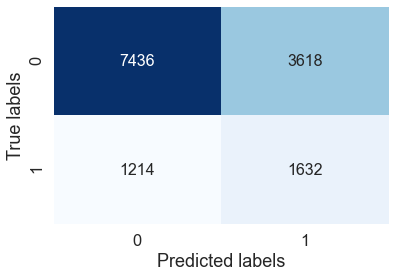

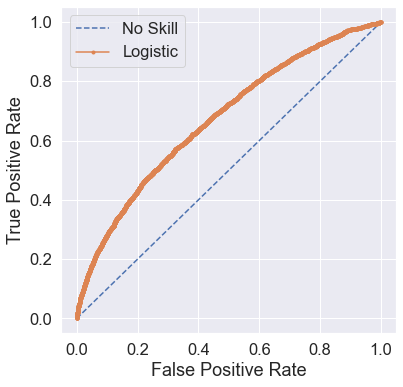

In [55]:
xgb_clf.fit(X_train, y_train)

# Predicting on the test data
pred_test = xgb_clf.predict(X_valid)

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = xgb_clf.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

## Oversampling/SMOTE/ADASYN Sampling Techniques
##### Sampleing techniques are used since the target variable is baised, in here diefferent types of sampling techniques are tested to derive the best outcome. Easy ensemble classifier from imblearn is used since it gives better output than other regular models. Undersampling is avoided since the given data is limited, undersampling could lead to a potential loss in information.

### Oversampling
##### Oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.

In [56]:
os=RandomOverSampler(0.75)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 25793, 1: 6639})
The number of classes after fit Counter({0: 25793, 1: 19344})


C:\Users\AKASH\anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

[[7059 3995]
 [1151 1695]]
0.6297841726618705
              precision    recall  f1-score   support

           0       0.86      0.64      0.73     11054
           1       0.30      0.60      0.40      2846

    accuracy                           0.63     13900
   macro avg       0.58      0.62      0.57     13900
weighted avg       0.74      0.63      0.66     13900

The f1 score for the testing data: 0.3971415182755389
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.670


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

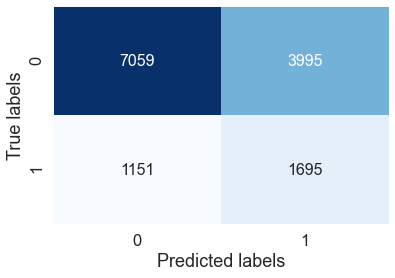

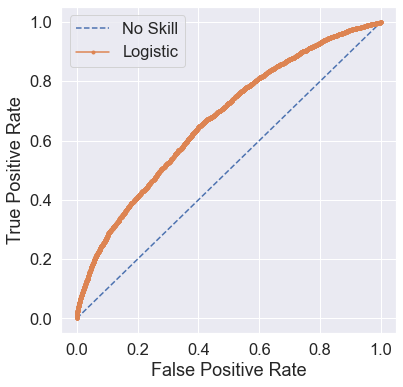

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

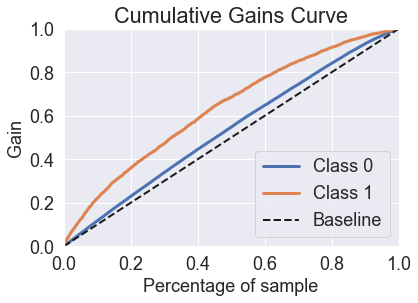

In [57]:
easy = make_pipeline(
    preprocess,
    EasyEnsembleClassifier())

easy.fit(X_train_ns, y_train_ns)

# Predicting on the test data
pred_test = easy.predict(X_valid)
print(confusion_matrix(y_valid,pred_test))
print(accuracy_score(y_valid,pred_test))
print(classification_report(y_valid,pred_test))

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = easy.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

# Deriving Class probabilities
predicted_probabilities = easy.predict_proba(X_valid)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probabilities)

### SMOTE
##### Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input.

In [58]:
sm=SMOTETomek(0.75)
X_train_sm,y_train_sm=sm.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_sm)))

C:\Users\AKASH\anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


The number of classes before fit Counter({0: 25793, 1: 6639})
The number of classes after fit Counter({0: 25183, 1: 18734})


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

[[7228 3826]
 [1385 1461]]
0.6251079136690647
              precision    recall  f1-score   support

           0       0.84      0.65      0.74     11054
           1       0.28      0.51      0.36      2846

    accuracy                           0.63     13900
   macro avg       0.56      0.58      0.55     13900
weighted avg       0.72      0.63      0.66     13900

The f1 score for the testing data: 0.3592770195499816
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.628


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

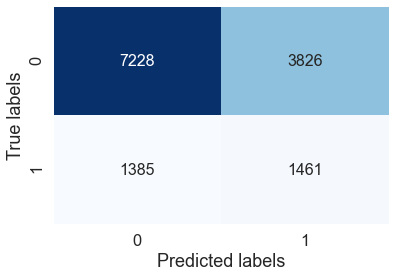

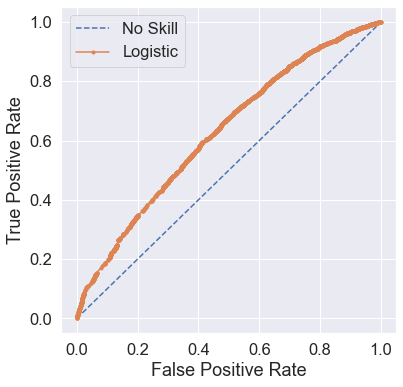

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

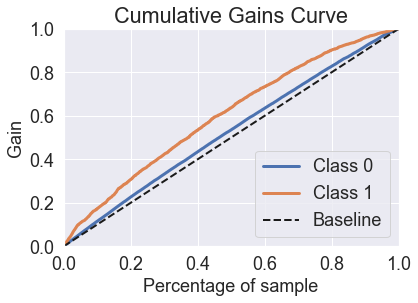

In [59]:
easy = make_pipeline(
    preprocess,
    EasyEnsembleClassifier())

easy.fit(X_train_sm, y_train_sm)

# Predicting on the test data
pred_test = easy.predict(X_valid)
print(confusion_matrix(y_valid,pred_test))
print(accuracy_score(y_valid,pred_test))
print(classification_report(y_valid,pred_test))

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = easy.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

# Deriving Class probabilities
predicted_probabilities = easy.predict_proba(X_valid)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probabilities)

### ADASYN 
##### ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.

In [61]:
ad=ADASYN()
X_train_ad,y_train_ad=ad.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ad)))

The number of classes before fit Counter({0: 25793, 1: 6639})
The number of classes after fit Counter({1: 26144, 0: 25793})


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['email_acitivity',
                                                   'log_number_contacts',
                                                   'log_it_spend_networking',
                                                   'log_cloud_others'])])),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

[[7704 3350]
 [1572 1274]]
0.6458992805755396
              precision    recall  f1-score   support

           0       0.83      0.70      0.76     11054
           1       0.28      0.45      0.34      2846

    accuracy                           0.65     13900
   macro avg       0.55      0.57      0.55     13900
weighted avg       0.72      0.65      0.67     13900

The f1 score for the testing data: 0.3410977242302543
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.610


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

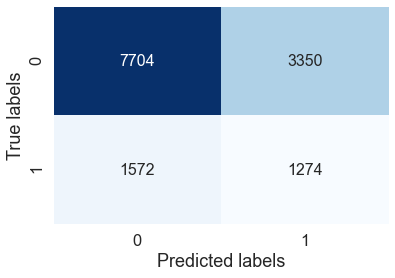

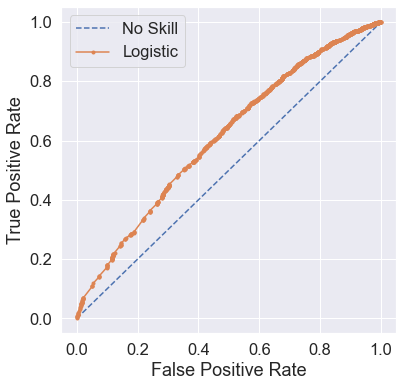

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

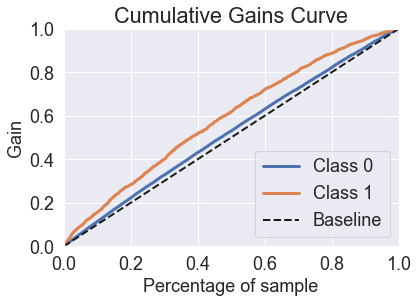

In [62]:
easy = make_pipeline(
    preprocess,
    EasyEnsembleClassifier())

easy.fit(X_train_ad, y_train_ad)

# Predicting on the test data
pred_test = easy.predict(X_valid)
print(confusion_matrix(y_valid,pred_test))
print(accuracy_score(y_valid,pred_test))
print(classification_report(y_valid,pred_test))

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = easy.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

# Deriving Class probabilities
predicted_probabilities = easy.predict_proba(X_valid)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probabilities)

## Final Analysis

### First the target variable itself is baised with only 5% purchased transaction. There is a vault with the provided data itself in relate to the target variable purchase_event, where enteries from past purchase from cloud,networking and others are not included. So all of this data are merged to the target variable to increase the predictablity. Feature selection is perfomed but later avoided since it reduVarious sampling tecniques are used to balance the bais in the data, but regular splitting with statifies split on target variable and SMOTE reacts well to this type of data. Easyensemble and XGBoost shows better outcome with higher F-1 scores. The F-score, also called the F1-score, is a measure of a model's accuracy on a dataset. The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall. In a problem with imbalanced data, F-1 is given more importance than ROC-AUC. 